# Final Project: Party Animal Steam Game Review Analysis

## Background:
In this real business scenario, one of our team members is affiliated with a venture capital firm that invested in a gaming company two years ago. This company developed 'Party Animal,' an online party game, the vc firm have now reached a critical milestone where they must decide whether to double down the investment in the company or maintain initial funding level and consider future exit strategies. Part of our analysis involves collecting genuine customer feedback from Steam to gauge user sentiment. This will help investment team verify whether the assumptions made during the initial investment regarding the game's market reception still hold true and if they meet or exceed the expectations.

## Project Goal:
Our objective is to leverage text analysis techniques on Party Animals' user feedback, understand how users like and dislike about the game. The results can help to advice the founding team on how to improve their future products and also for the venture investment team to evaluate if the game has potential to become really successful.

## Data Acquisition

The data was retrieved from an API provided by Steamworks; the documentation is accessible at: https://partner.steamgames.com/doc/store/getreviews. When specifying parameters, it's advisable to keep them simple by including only English-language reviews. Given that the game launched six months ago and may have initially received promotional or inauthentic reviews to generate viral attention, we have chosen to focus on reviews from the most recent 30 days. Furthermore, we only considered reviews from users who purchased the game directly from Steam to ensure the feedback reflects genuine player experiences as accurately as possible.

In [ ]:
import requests
import urllib.parse
import pandas as pd
from pandas.io.json import json_normalize

In [ ]:
import requests

# Initialize parameters
appid = '1260320'  # Game ID
parameters = {
    'json': 1,
    'filter': 'recent',
    'language': 'english',
    'day_range': 30,
    'review_type': 'all',
    'purchase_type': 'steam',
    'num_per_page': 100,
    'cursor': '*'  # Initial cursor
}

all_reviews = []
base_url = f"http://store.steampowered.com/appreviews/{appid}"

while True:
    response = requests.get(base_url, params=parameters)
    if response.status_code == 200:
        data = response.json()
        reviews = data.get('reviews', [])
        if not reviews:
            break  # No more reviews, exit loop
        all_reviews.extend(reviews)
        next_cursor = data.get('cursor', '*')
        if next_cursor == parameters['cursor']:  # Check if the cursor hasn't changed
            print("Cursor hasn't changed, breaking loop to avoid infinite loop.")
            break
        parameters['cursor'] = next_cursor  # Update cursor for the next request
        print(f"Cursor updated to: {next_cursor}")
    else:
        print(f"Failed to fetch reviews: HTTP {response.status_code}")
        break

print(f"Total reviews fetched: {len(all_reviews)}")

In [ ]:
results=pd.DataFrame(all_reviews)

In [ ]:
results.head()

In [ ]:
author_expanded = json_normalize(df['author'])
results_expanded = df.join(author_expanded).drop(columns=['author'])

results_expanded

In [ ]:
results_expanded.to_excel(("Party_Animal_Steam_Review_Data_processed.csv")

## Analytics

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

In [ ]:
df = pd.read_csv("Party_Animal_Steam_Review_Data_processed.csv")

### User segmentation using KNN
The API provides user data including 'num_games_owned', 'num_reviews', 'playtime_forever', 'playtime_last_two_weeks', 'playtime_at_review', and 'last_played', effectively showcasing the level of user engagement and experience with Steam and gaming. These features can be utilized to segment players into categories of more engaged and experienced ones versus less engaged or newcomers to Steam. By segmenting the customers, we can gain insights into player satisfaction across different target groups.

In [17]:
columns = ['num_games_owned', 'num_reviews', 'playtime_forever', 'playtime_last_two_weeks', 'playtime_at_review', 'last_played']

# Checking for missing values in the specified columns
missing_values = df[columns].isnull().sum()

print(missing_values)

num_games_owned            0
num_reviews                0
playtime_forever           0
playtime_last_two_weeks    0
playtime_at_review         0
last_played                0
dtype: int64


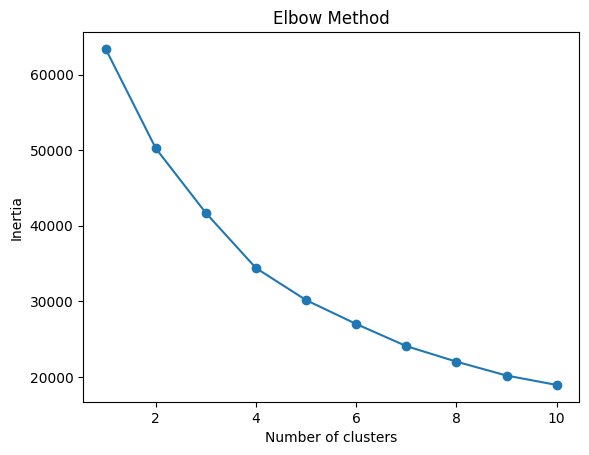

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Determining the number of clusters using Elbow Method
features = ['num_games_owned', 'num_reviews', 'playtime_forever', 'playtime_last_two_weeks', 'playtime_at_review', 'last_played']

# Standardizing the features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

#Plotting the Elbow Method
import matplotlib.pyplot as plt
plt.plot(range(1, 11), inertia, marker='o'); plt.title('Elbow Method'); plt.xlabel('Number of clusters'); plt.ylabel('Inertia'); plt.show()

#Since there are no optimal clusters detected will use the Silhouette Score approach

Number of clusters: 2, Silhouette Score: 0.64
Number of clusters: 3, Silhouette Score: 0.31
Number of clusters: 4, Silhouette Score: 0.32
Number of clusters: 5, Silhouette Score: 0.33
Number of clusters: 6, Silhouette Score: 0.34
Number of clusters: 7, Silhouette Score: 0.35
Number of clusters: 8, Silhouette Score: 0.36
Number of clusters: 9, Silhouette Score: 0.36
Number of clusters: 10, Silhouette Score: 0.34


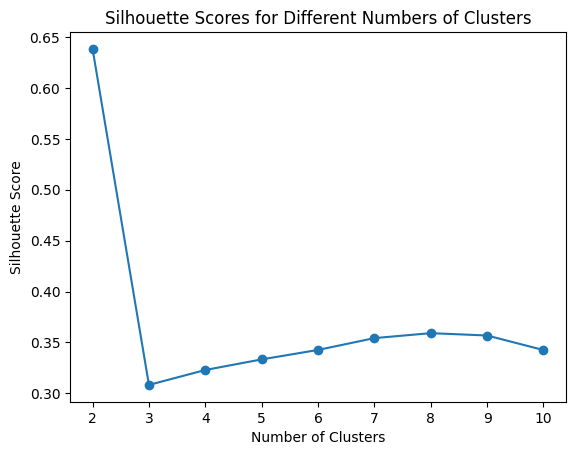

The optimal number of clusters is: 2


In [19]:
from sklearn.metrics import silhouette_score

#Silhouette Score Approach:

range_n_clusters = list(range(2, 11))
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Number of clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.2f}")

# Plotting the silhouette scores
import matplotlib.pyplot as plt

plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Identify the optimal number of clusters as the one with the highest Silhouette Score
optimal_n_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"The optimal number of clusters is: {optimal_n_clusters}")

In [20]:
# Choose the k after which the inertia decrease starts to diminish and the optimal number is 2
k_optimal = 2

# Clustering with the chosen k
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(df_scaled)

<ipython-input-21-6825c89b4635>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='cluster', y=feature, ax=ax, palette="coolwarm", errorbar=None)
<ipython-input-21-6825c89b4635>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='cluster', y=feature, ax=ax, palette="coolwarm", errorbar=None)
<ipython-input-21-6825c89b4635>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='cluster', y=feature, ax=ax, palette="coolwarm", errorbar=None)
<ipython-input-21-6825c89b4635>:16: FutureWarning: 

Passing `palette` witho

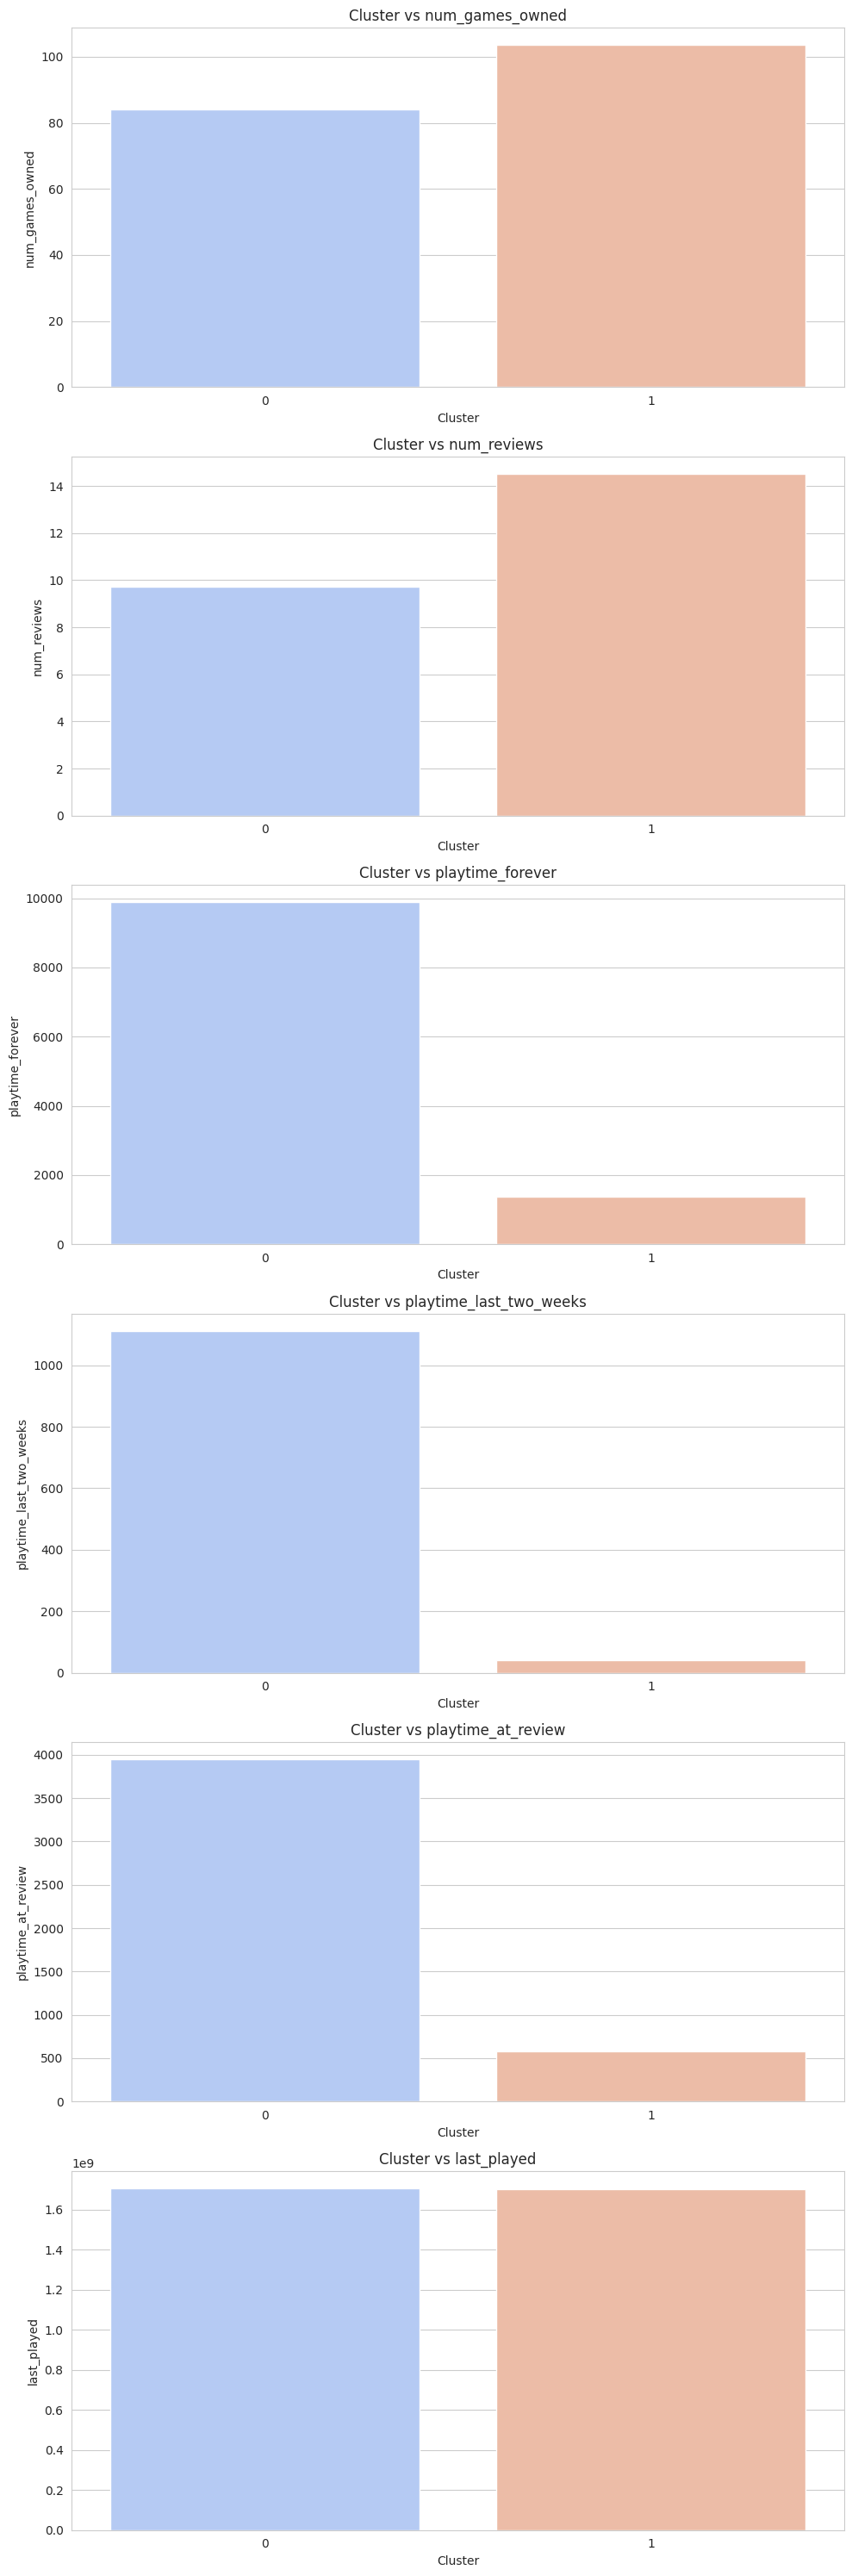

In [21]:
# Plot the clusters against the user engagement data and see how does it looks like
features = ['num_games_owned', 'num_reviews', 'playtime_forever', 'playtime_last_two_weeks', 'playtime_at_review', 'last_played']

# Set the style of seaborn
sns.set_style("whitegrid")

# Create a figure and a set of subplots
fig, axs = plt.subplots(len(features), 1, figsize=(10, 5 * len(features)))

# Check if there's only one feature to plot to handle indexing
single_plot = len(features) == 1

for i, feature in enumerate(features):
    # Plot each feature in a separate subplot
    ax = axs[i] if not single_plot else axs
    sns.barplot(data=df, x='cluster', y=feature, ax=ax, palette="coolwarm", errorbar=None)
    ax.set_title(f'Cluster vs {feature}')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()

The segmentation results in two distinct groups: Hardcore and Casual players. Hardcore players are characterized by more accumulated playtime and a narrower focus on fewer games, with less frequent review writing.

### POS tagging for fetching important attributes

In [22]:
df.head()

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,timestamp_dev_responded,developer_response,steamid,num_games_owned,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,cluster
0,157603005,english,Fun game to play when you've had a long day an...,1707077354,1707077354,True,0,0,0.0,0,...,NaN,NaN,76561199401546423,0,1,2027,322,1986,1707079884,1
1,157602265,english,Pros:\n-Animals\n-Party\n-Funny mechanics\n-A ...,1707076676,1707076676,True,0,0,0.0,0,...,NaN,NaN,76561198056822321,0,2,316,316,316,1707076353,1
2,157598111,english,10/10 Would drop kick a cat without feeling bad,1707072837,1707072837,True,0,1,0.0,0,...,NaN,NaN,76561198428748427,0,1,847,410,804,1707075660,1
3,157592673,english,"Very fun game. The animals are very cute, the ...",1707068019,1707068019,True,0,0,0.0,0,...,NaN,NaN,76561197987140501,0,10,7864,600,7712,1707109536,0
4,157588222,english,Game has been out for 4 months and they only a...,1707064205,1707064205,False,0,0,0.0,0,...,NaN,NaN,76561198024864749,375,17,1456,0,1456,1701029993,1


In [23]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

# Function to find patterns like adjective-noun and noun-adjective
def find_adj_noun_patterns(text):
    # Tokenize and POS tag
    tokens = word_tokenize(text)
    tags = nltk.pos_tag(tokens)

    # Look for patterns: adjective followed by a noun and noun followed by an adjective
    patterns = []
    for i in range(len(tags) - 1):
        word1, tag1 = tags[i]
        word2, tag2 = tags[i + 1]
        if (tag1 in ['JJ', 'JJR', 'JJS'] and tag2 in ['NN', 'NNS']) or \
           (tag1 in ['NN', 'NNS'] and tag2 in ['JJ', 'JJR', 'JJS']):
            patterns.append(word1 + ' ' + word2)
    return patterns

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
# Apply the function to each review
df['review'] = df['review'].astype(str)
df['review'] = df['review'].str.lower()
df['review'] = df['review'].str.replace('-', '')
df['review'] = df['review'].str.replace('*', '')
df['attributes_patterns'] = df['review'].apply(find_adj_noun_patterns)

<ipython-input-24-0003695bc44f>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['review'] = df['review'].str.replace('*', '')


In [25]:
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
def fetch_words_by_pos(text):
    tokens = word_tokenize(text)
    tags = pos_tag(tokens)

    words_by_pos = []

    for word, tag in tags:
        if tag in ['JJ', 'JJR', 'JJS']:
            words_by_pos.append(word)
        elif tag in ['NN', 'NNS', 'NNP', 'NNPS']:
            words_by_pos.append(word)
        elif tag in ['RB', 'RBR', 'RBS']:
            words_by_pos.append(word)
        elif tag.startswith('VB'):
            words_by_pos.append(word)

    return words_by_pos


# Apply the function to each review and store the result in a new column
df['POS_all'] = df['review'].apply(fetch_words_by_pos)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
# Show top 100 words and frequency to understand the attributes

from collections import Counter

# Flatten all the lists in the column into one big list
all_patterns = [pattern for sublist in df['attributes_patterns'] for pattern in sublist]

# Count the occurrences of each pattern
pattern_counts = Counter(all_patterns)

# Get the top 100 most common patterns
top_100_patterns = pattern_counts.most_common(100)

top_100_df = pd.DataFrame(top_100_patterns, columns=['Pattern', 'Count'])

top_100_dict = dict(top_100_patterns)

print(top_100_df)

           Pattern  Count
0        good game    364
1         fun game    336
2       great game    327
3           game i    201
4     offline mode    201
..             ...    ...
95      good laugh     17
96     first place     17
97   free currency     17
98     new content     16
99  different maps     16

[100 rows x 2 columns]


### Sentiment Analysis
Experiment with Vader and Spacy to understand different model's performance. For processing the sentiment, the both Nouns only and all POS were went through the Vader and for spacy, despite these two, the entire review also processed additonally, the goal is to see which way can generate the best sentiment score, as the dataset provided a column "voted up" represents if user think they would recommend the game to their friends, this information can be used as benchmark to evaluate the sentiment anlaysis results.

In [27]:
# Make sure lowercased all words except header
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

#### Sentiment Analysis on Nouns POS with Vader

In [28]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [29]:
# Load the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Perform sentiment analysis Nouns POS
df['sentiment_scores_noun_pos_vader'] = df['attributes_patterns'].apply(lambda x: sia.polarity_scores(' '.join(x)) if isinstance(x, list) else sia.polarity_scores(x))
df['sentiment_score_noun_pos_vader'] = df['sentiment_scores_noun_pos_vader'].apply(lambda x: x['compound'])

df.head()

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,num_reviews,playtime_forever,playtime_last_two_weeks,playtime_at_review,last_played,cluster,attributes_patterns,POS_all,sentiment_scores_noun_pos_vader,sentiment_score_noun_pos_vader
0,157603005,english,fun game to play when you've had a long day an...,1707077354,1707077354,True,0,0,0.0,0,...,1,2027,322,1986,1707079884,1,"[long day, fun easy, easy game]","[fun, game, play, 've, had, long, day, just, w...","{'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'comp...",0.8442
1,157602265,english,pros:\nanimals\nparty\nfunny mechanics\na bunc...,1707076676,1707076676,True,0,0,0.0,0,...,2,316,316,316,1707076353,1,"[party funny, funny mechanics, short while, ra...","[pros, animals, party, funny, mechanics, bunch...","{'neg': 0.0, 'neu': 0.638, 'pos': 0.362, 'comp...",0.8176
2,157598111,english,10/10 would drop kick a cat without feeling bad,1707072837,1707072837,True,0,1,0.0,0,...,1,847,410,804,1707075660,1,[],"[drop, kick, cat, feeling, bad]","{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000
3,157592673,english,"very fun game. the animals are very cute, the ...",1707068019,1707068019,True,0,0,0.0,0,...,10,7864,600,7712,1707109536,0,"[fun game, new skins/characters]","[very, fun, game, animals, are, very, cute, mu...","{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'comp...",0.5106
4,157588222,english,game has been out for 4 months and they only a...,1707064205,1707064205,False,0,0,0.0,0,...,17,1456,0,1456,1701029993,1,"[new content, old level, social hub]","[game, has, been, months, only, added, level, ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


#### Sentiment Analysis on All POS with Vader

In [30]:
# Perform sentiment analysis All POS, including Nouns, Verbs, Adjectives, Adverbs, etc.
df['sentiment_scores_all_pos_vader'] = df['POS_all'].apply(lambda x: sia.polarity_scores(' '.join(x)) if isinstance(x, list) else sia.polarity_scores(x))
df['sentiment_score_all_pos_vader'] = df['sentiment_scores_all_pos_vader'].apply(lambda x: x['compound'])

df.head()

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,playtime_last_two_weeks,playtime_at_review,last_played,cluster,attributes_patterns,POS_all,sentiment_scores_noun_pos_vader,sentiment_score_noun_pos_vader,sentiment_scores_all_pos_vader,sentiment_score_all_pos_vader
0,157603005,english,fun game to play when you've had a long day an...,1707077354,1707077354,True,0,0,0.0,0,...,322,1986,1707079884,1,"[long day, fun easy, easy game]","[fun, game, play, 've, had, long, day, just, w...","{'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'comp...",0.8442,"{'neg': 0.0, 'neu': 0.242, 'pos': 0.758, 'comp...",0.9719
1,157602265,english,pros:\nanimals\nparty\nfunny mechanics\na bunc...,1707076676,1707076676,True,0,0,0.0,0,...,316,316,1707076353,1,"[party funny, funny mechanics, short while, ra...","[pros, animals, party, funny, mechanics, bunch...","{'neg': 0.0, 'neu': 0.638, 'pos': 0.362, 'comp...",0.8176,"{'neg': 0.192, 'neu': 0.603, 'pos': 0.205, 'co...",0.3099
2,157598111,english,10/10 would drop kick a cat without feeling bad,1707072837,1707072837,True,0,1,0.0,0,...,410,804,1707075660,1,[],"[drop, kick, cat, feeling, bad]","{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,"{'neg': 0.615, 'neu': 0.22, 'pos': 0.165, 'com...",-0.6249
3,157592673,english,"very fun game. the animals are very cute, the ...",1707068019,1707068019,True,0,0,0.0,0,...,600,7712,1707109536,0,"[fun game, new skins/characters]","[very, fun, game, animals, are, very, cute, mu...","{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'comp...",0.5106,"{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound...",0.9322
4,157588222,english,game has been out for 4 months and they only a...,1707064205,1707064205,False,0,0,0.0,0,...,0,1456,1701029993,1,"[new content, old level, social hub]","[game, has, been, months, only, added, level, ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


#### Sentiment Analysis on Entire Review with SpaCy

In [38]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

# Load the SpaCy model
nlp = spacy.load('en_core_web_sm')

# Add the SpaCyTextBlob component to the pipeline
nlp.add_pipe('spacytextblob')

# Perform sentiment analysis on the "review" column
df['sentiment_score_review_spacy'] = df['review'].apply(lambda x: nlp(str(x))._.polarity)

df.head()

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,playtime_at_review,last_played,cluster,attributes_patterns,POS_all,sentiment_scores_noun_pos_vader,sentiment_score_noun_pos_vader,sentiment_scores_all_pos_vader,sentiment_score_all_pos_vader,sentiment_score_review_spacy
0,157603005,english,fun game to play when you've had a long day an...,1707077354,1707077354,True,0,0,0.0,0,...,1986,1707079884,1,"[long day, fun easy, easy game]","[fun, game, play, 've, had, long, day, just, w...","{'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'comp...",0.8442,"{'neg': 0.0, 'neu': 0.242, 'pos': 0.758, 'comp...",0.9719,0.031481
1,157602265,english,pros:\nanimals\nparty\nfunny mechanics\na bunc...,1707076676,1707076676,True,0,0,0.0,0,...,316,1707076353,1,"[party funny, funny mechanics, short while, ra...","[pros, animals, party, funny, mechanics, bunch...","{'neg': 0.0, 'neu': 0.638, 'pos': 0.362, 'comp...",0.8176,"{'neg': 0.192, 'neu': 0.603, 'pos': 0.205, 'co...",0.3099,-0.000231
2,157598111,english,10/10 would drop kick a cat without feeling bad,1707072837,1707072837,True,0,1,0.0,0,...,804,1707075660,1,[],"[drop, kick, cat, feeling, bad]","{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,"{'neg': 0.615, 'neu': 0.22, 'pos': 0.165, 'com...",-0.6249,-0.700000
3,157592673,english,"very fun game. the animals are very cute, the ...",1707068019,1707068019,True,0,0,0.0,0,...,7712,1707109536,0,"[fun game, new skins/characters]","[very, fun, game, animals, are, very, cute, mu...","{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'comp...",0.5106,"{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound...",0.9322,0.218052
4,157588222,english,game has been out for 4 months and they only a...,1707064205,1707064205,False,0,0,0.0,0,...,1456,1701029993,1,"[new content, old level, social hub]","[game, has, been, months, only, added, level, ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-0.116856


In [37]:
pip install spacytextblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.5/636.5 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 0.17.1
    Uninstalling textblob-0.17.1:
      Successfully uninstalled textblob-0.17.1


#### Sentiment Analysis on Nouns POS with SpaCy

In [39]:
# Perform sentiment analysis on the "attributes_patterns" column
df['sentiment_score_noun_pos_spacy'] = df['attributes_patterns'].apply(lambda x: nlp(str(x))._.polarity)
df.head()

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,last_played,cluster,attributes_patterns,POS_all,sentiment_scores_noun_pos_vader,sentiment_score_noun_pos_vader,sentiment_scores_all_pos_vader,sentiment_score_all_pos_vader,sentiment_score_review_spacy,sentiment_score_noun_pos_spacy
0,157603005,english,fun game to play when you've had a long day an...,1707077354,1707077354,True,0,0,0.0,0,...,1707079884,1,"[long day, fun easy, easy game]","[fun, game, play, 've, had, long, day, just, w...","{'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'comp...",0.8442,"{'neg': 0.0, 'neu': 0.242, 'pos': 0.758, 'comp...",0.9719,0.031481,0.143333
1,157602265,english,pros:\nanimals\nparty\nfunny mechanics\na bunc...,1707076676,1707076676,True,0,0,0.0,0,...,1707076353,1,"[party funny, funny mechanics, short while, ra...","[pros, animals, party, funny, mechanics, bunch...","{'neg': 0.0, 'neu': 0.638, 'pos': 0.362, 'comp...",0.8176,"{'neg': 0.192, 'neu': 0.603, 'pos': 0.205, 'co...",0.3099,-0.000231,0.166667
2,157598111,english,10/10 would drop kick a cat without feeling bad,1707072837,1707072837,True,0,1,0.0,0,...,1707075660,1,[],"[drop, kick, cat, feeling, bad]","{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,"{'neg': 0.615, 'neu': 0.22, 'pos': 0.165, 'com...",-0.6249,-0.700000,0.000000
3,157592673,english,"very fun game. the animals are very cute, the ...",1707068019,1707068019,True,0,0,0.0,0,...,1707109536,0,"[fun game, new skins/characters]","[very, fun, game, animals, are, very, cute, mu...","{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'comp...",0.5106,"{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound...",0.9322,0.218052,0.012121
4,157588222,english,game has been out for 4 months and they only a...,1707064205,1707064205,False,0,0,0.0,0,...,1701029993,1,"[new content, old level, social hub]","[game, has, been, months, only, added, level, ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-0.116856,0.089899


#### Sentiment Analysis on All POS with SpaCy

In [40]:
# Perform sentiment analysis on the "POS_all" column, including Nouns, Verbs, Adjectives, Adverbs, etc.
df['sentiment_score_all_pos_spacy'] = df['POS_all'].apply(lambda x: nlp(str(x))._.polarity)
df.head()

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,cluster,attributes_patterns,POS_all,sentiment_scores_noun_pos_vader,sentiment_score_noun_pos_vader,sentiment_scores_all_pos_vader,sentiment_score_all_pos_vader,sentiment_score_review_spacy,sentiment_score_noun_pos_spacy,sentiment_score_all_pos_spacy
0,157603005,english,fun game to play when you've had a long day an...,1707077354,1707077354,True,0,0,0.0,0,...,1,"[long day, fun easy, easy game]","[fun, game, play, 've, had, long, day, just, w...","{'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'comp...",0.8442,"{'neg': 0.0, 'neu': 0.242, 'pos': 0.758, 'comp...",0.9719,0.031481,0.143333,0.031481
1,157602265,english,pros:\nanimals\nparty\nfunny mechanics\na bunc...,1707076676,1707076676,True,0,0,0.0,0,...,1,"[party funny, funny mechanics, short while, ra...","[pros, animals, party, funny, mechanics, bunch...","{'neg': 0.0, 'neu': 0.638, 'pos': 0.362, 'comp...",0.8176,"{'neg': 0.192, 'neu': 0.603, 'pos': 0.205, 'co...",0.3099,-0.000231,0.166667,-0.011719
2,157598111,english,10/10 would drop kick a cat without feeling bad,1707072837,1707072837,True,0,1,0.0,0,...,1,[],"[drop, kick, cat, feeling, bad]","{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,"{'neg': 0.615, 'neu': 0.22, 'pos': 0.165, 'com...",-0.6249,-0.700000,0.000000,-0.700000
3,157592673,english,"very fun game. the animals are very cute, the ...",1707068019,1707068019,True,0,0,0.0,0,...,0,"[fun game, new skins/characters]","[very, fun, game, animals, are, very, cute, mu...","{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'comp...",0.5106,"{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound...",0.9322,0.218052,0.012121,0.237727
4,157588222,english,game has been out for 4 months and they only a...,1707064205,1707064205,False,0,0,0.0,0,...,1,"[new content, old level, social hub]","[game, has, been, months, only, added, level, ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-0.116856,0.089899,-0.091288


In [41]:
df_test = df

#### Compare the sentiments scores with voted_up label, and set final sentiment score calculation approach.

In [42]:
# Create consistency columns for each sentiment score
df_test['consistency_noun_pos_vader'] = df_test.apply(lambda row: 'consistent' if (row['sentiment_score_noun_pos_vader'] > 0 and row['voted_up']) or (row['sentiment_score_noun_pos_vader'] < 0 and not row['voted_up']) else 'inconsistent', axis=1)
df_test['consistency_all_pos_vader'] = df_test.apply(lambda row: 'consistent' if (row['sentiment_score_all_pos_vader'] > 0 and row['voted_up']) or (row['sentiment_score_all_pos_vader'] < 0 and not row['voted_up']) else 'inconsistent', axis=1)
df_test['consistency_review_spacy'] = df_test.apply(lambda row: 'consistent' if (row['sentiment_score_review_spacy'] > 0 and row['voted_up']) or (row['sentiment_score_review_spacy'] < 0 and not row['voted_up']) else 'inconsistent', axis=1)
df_test['consistency_noun_pos_spacy'] = df_test.apply(lambda row: 'consistent' if (row['sentiment_score_noun_pos_spacy'] > 0 and row['voted_up']) or (row['sentiment_score_noun_pos_spacy'] <= 0 and not row['voted_up']) else 'inconsistent', axis=1)
df_test['consistency_all_pos_spacy'] = df_test.apply(lambda row: 'consistent' if (row['sentiment_score_all_pos_spacy'] > 0 and row['voted_up']) or (row['sentiment_score_all_pos_spacy'] < 0 and not row['voted_up']) else 'inconsistent', axis=1)

df_test.head()

,recommendationid,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,...,sentiment_scores_all_pos_vader,sentiment_score_all_pos_vader,sentiment_score_review_spacy,sentiment_score_noun_pos_spacy,sentiment_score_all_pos_spacy,consistency_noun_pos_vader,consistency_all_pos_vader,consistency_review_spacy,consistency_noun_pos_spacy,consistency_all_pos_spacy
0,157603005,english,fun game to play when you've had a long day an...,1707077354,1707077354,True,0,0,0.0,0,...,"{'neg': 0.0, 'neu': 0.242, 'pos': 0.758, 'comp...",0.9719,0.031481,0.143333,0.031481,consistent,consistent,consistent,consistent,consistent
1,157602265,english,pros:\nanimals\nparty\nfunny mechanics\na bunc...,1707076676,1707076676,True,0,0,0.0,0,...,"{'neg': 0.192, 'neu': 0.603, 'pos': 0.205, 'co...",0.3099,-0.000231,0.166667,-0.011719,consistent,consistent,inconsistent,consistent,inconsistent
2,157598111,english,10/10 would drop kick a cat without feeling bad,1707072837,1707072837,True,0,1,0.0,0,...,"{'neg': 0.615, 'neu': 0.22, 'pos': 0.165, 'com...",-0.6249,-0.700000,0.000000,-0.700000,inconsistent,inconsistent,inconsistent,inconsistent,inconsistent
3,157592673,english,"very fun game. the animals are very cute, the ...",1707068019,1707068019,True,0,0,0.0,0,...,"{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound...",0.9322,0.218052,0.012121,0.237727,consistent,consistent,consistent,consistent,consistent
4,157588222,english,game has been out for 4 months and they only a...,1707064205,1707064205,False,0,0,0.0,0,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,-0.116856,0.089899,-0.091288,inconsistent,inconsistent,consistent,inconsistent,consistent


#### Consistency Plot
From the comparison, the best approach to do the sentimental analyssi is to use the entire review as an input and calculated by using SapCy

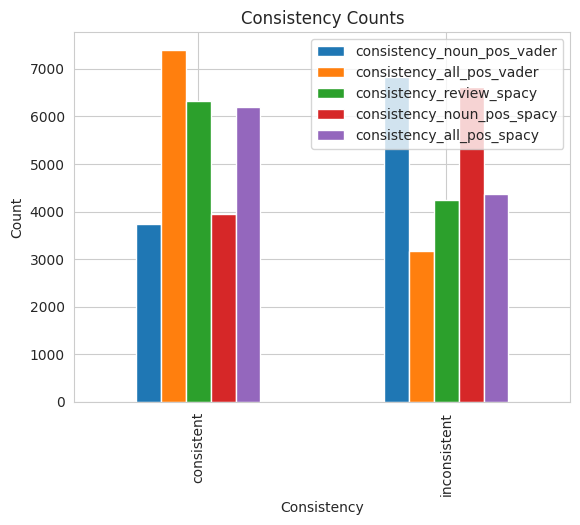

In [43]:
import matplotlib.pyplot as plt

# Count the inconsistencies
Consistency_counts = df_test[['consistency_noun_pos_vader', 'consistency_all_pos_vader', 'consistency_review_spacy', 'consistency_noun_pos_spacy', 'consistency_all_pos_spacy']].apply(pd.value_counts)

# Plot the inconsistencies
Consistency_counts.plot(kind='bar')
plt.xlabel('Consistency')
plt.ylabel('Count')
plt.title('Consistency Counts')
plt.show()

#### Calculate the accuracy rate of each sentiment analysis method

consistent / column count:
Columns inclduing: 'consistency_noun_pos_vader', 'consistency_all_pos_vader', 'consistency_review_spacy', 'consistency_noun_pos_spacy', 'consistency_all_pos_spacy'

In [44]:
# Calculate the accuracy rate
accuracy_rates = {
    'consistency_noun_pos_vader': df_test['consistency_noun_pos_vader'].value_counts().get('consistent', 0) / len(df_test),
    'consistency_all_pos_vader': df_test['consistency_all_pos_vader'].value_counts().get('consistent', 0) / len(df_test),
    'consistency_review_spacy': df_test['consistency_review_spacy'].value_counts().get('consistent', 0) / len(df_test),
    'consistency_noun_pos_spacy': df_test['consistency_noun_pos_spacy'].value_counts().get('consistent', 0) / len(df_test),
    'consistency_all_pos_spacy': df_test['consistency_all_pos_spacy'].value_counts().get('consistent', 0) / len(df_test)
}

# Create a dataframe from the accuracy rates
accuracy_df = pd.DataFrame.from_dict(accuracy_rates, orient='index', columns=['Accuracy Rate'])

# Sort the dataframe in descending order
accuracy_df = accuracy_df.sort_values(by='Accuracy Rate', ascending=False)

accuracy_df

,Accuracy Rate
consistency_all_pos_vader,0.700360
consistency_review_spacy,0.597672
consistency_all_pos_spacy,0.585841
consistency_noun_pos_spacy,0.374219
consistency_noun_pos_vader,0.353492


#### Plot the sentiment socre for both clusters
Use the ALL POS data as input and processed with Vader

<ipython-input-46-9b378a9a22eb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_test, x='cluster', y='sentiment_score_all_pos_vader', ax=axes[0], palette=colors)
<ipython-input-46-9b378a9a22eb>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_test, x='cluster', y='sentiment_score_all_pos_vader', ax=axes[1], palette=colors)


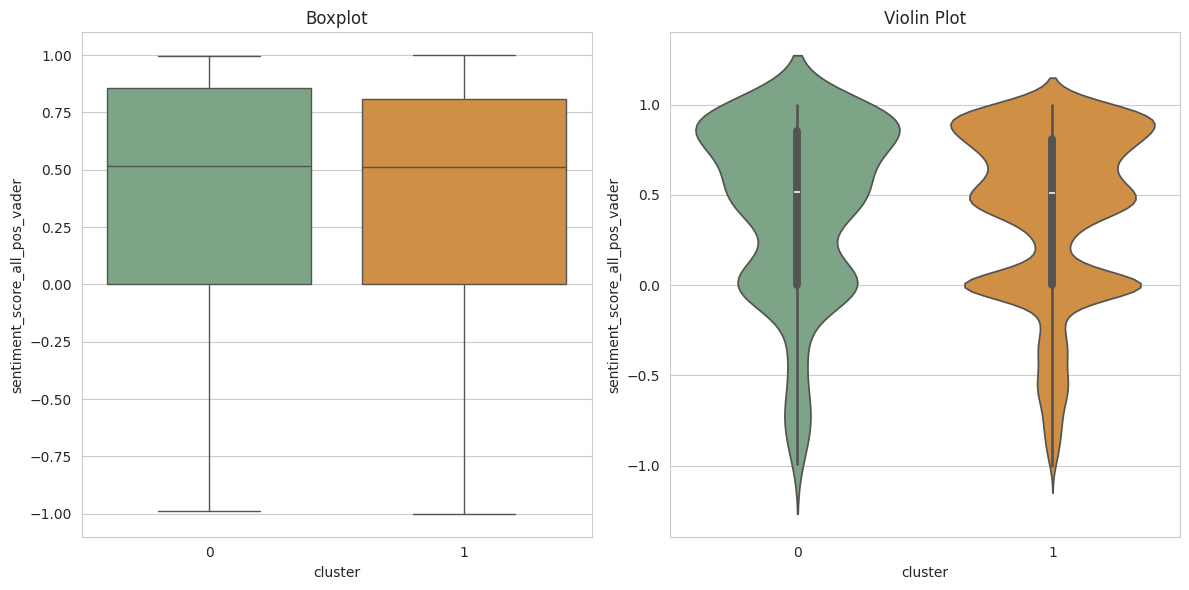

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = ['#77aa83', '#e6902e']
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot
sns.boxplot(data=df_test, x='cluster', y='sentiment_score_all_pos_vader', ax=axes[0], palette=colors)
axes[0].set_title('Boxplot')

# Violin plot
sns.violinplot(data=df_test, x='cluster', y='sentiment_score_all_pos_vader', ax=axes[1], palette=colors)
axes[1].set_title('Violin Plot')

plt.tight_layout()
plt.show()

Analysis of sentiment distribution through box and violin plots shows that both hardcore and casual players exhibit similar sentiment patterns, with casual players displaying a wider range of extreme sentiments. A notable finding is that hardcore players generally have a slightly more positive sentiment towards the game.

In [ ]:
#df.to_csv('Vader vs. Spacy Sentiments Scores.csv', index=False)

### Important Attribute Identification
In this phase, we focus on pinpointing crucial game features that sway users' decisions to endorse the game. By examining the most significant 200 features identified through patterns of part-of-speech (POS) tagging, we utilize these features as predictive variables in a Random Forest classification model. The model's target variable is 'voted_up', which signifies whether a user recommends the game or not. The objective is to prioritize these leading features according to their importance scores, reflecting their impact on user recommendation behavior.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Split the CSV into two segments based on the cluster column
segment_0 = df[df['cluster'] == 0]
segment_1 = df[df['cluster'] == 1]

In [ ]:
print(len(segment_0),len(segment_1))

514 10052


#### Identify the top 200 attributes and Perform RF on Segment 0

In [ ]:
df_0 = segment_0

In [ ]:
if not isinstance(df_0['attributes_patterns'].iloc[0], str):
    pass
else:
    df_0['attributes_patterns'] = df_0['attributes_patterns'].str.strip('[]').str.split(', ')

# Flatten the list of lists and count occurrences of each word
word_counts = Counter(word for words in df_0['attributes_patterns'] for word in words)

# Create a DataFrame from the word counts
df_word_counts = pd.DataFrame.from_dict(word_counts, orient='index', columns=['Count'])

# Reset the index
df_word_counts.reset_index(inplace=True)

# Rename the columns
df_word_counts.columns = ['Word', 'Count']

# Sort the DataFrame in descending order of the count
df_word_counts = df_word_counts.sort_values(by='Count', ascending=False)

# Reset the index after sorting
df_word_counts.reset_index(drop=True, inplace=True)

# Clean up the word counts by removing the irrelevant characters
df_word_counts = df_word_counts[df_word_counts['Word'] != '']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ h1\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'’ t\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'/b ]\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ list\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ h3\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'* ]\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ b\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'* *\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ h2\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ url=https\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'] random\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'/list ]\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'//storage.googleapis.com/rebos_american_hamburger_stash/grabbing_issues_2.mp4 ]\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'//storage.googleapis.com/rebos_american_hamburger_stash/grabbing_issues.mp4 ]\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ /h3\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'/h2 ]\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'/h1 ]\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'//storage.googleapis.com/rebos_american_hamburger_stash/another_bomba_bridge.mp4 ]\'']

# Get the top 200 words
top_200_words = df_word_counts['Word'].head(200)
top_200_words.reset_index(drop=True, inplace=True)
top_200_words

0               good game
1                fun game
2                much fun
3              great game
4             quick match
              ...        
195    online requirement
196    much inconsistency
197        energetic game
198         favorite game
199              stop fun
Name: Word, Length: 200, dtype: object

In [ ]:
# Iterate over the top 200 words and create new columns in the original DataFrame
for word in top_200_words:
    df_0[word] = df_0['attributes_patterns'].apply(lambda x: 1 if word in x else 0)

/var/folders/dx/3j4_9y9n65sb4cftdp89qfnc0000gn/T/ipykernel_5487/3204370349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0[word] = df_0['attributes_patterns'].apply(lambda x: 1 if word in x else 0)
/var/folders/dx/3j4_9y9n65sb4cftdp89qfnc0000gn/T/ipykernel_5487/3204370349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0[word] = df_0['attributes_patterns'].apply(lambda x: 1 if word in x else 0)
/var/folders/dx/3j4_9y9n65sb4cftdp89qfnc0000gn/T/ipykernel_5487/3204370349.py:3: SettingWithCopyWa

In [ ]:
# Define your X and Y
X = df_0.drop(['voted_up',
             'recommendationid',
             'language',
             'review',
             'timestamp_created',
             'timestamp_updated',
             'votes_up',
             'votes_funny',
             'weighted_vote_score',
             'comment_count',
             'steam_purchase',
             'received_for_free',
             'written_during_early_access',
             'hidden_in_steam_china',
             'steam_china_location',
             'timestamp_dev_responded',
             'developer_response',
             'steamid',
             'num_games_owned',
             'num_reviews',
             'playtime_forever',
             'playtime_last_two_weeks',
             'playtime_at_review',
             'last_played',
             'attributes_patterns',
             'POS_all',
             'cluster',
             'sentiment_scores_noun_pos_vader',
             'sentiment_score_noun_pos_vader',
             'sentiment_scores_all_pos_vader',
             'sentiment_score_all_pos_vader',
             'sentiment_score_review_spacy' ,
             'sentiment_score_noun_pos_spacy',
             'sentiment_score_all_pos_spacy',
             'consistency_noun_pos_vader',
             'consistency_all_pos_vader',
             'consistency_review_spacy',
             'consistency_noun_pos_spacy',
             'consistency_all_pos_spacy'],
             axis=1)
Y = df_0['voted_up']

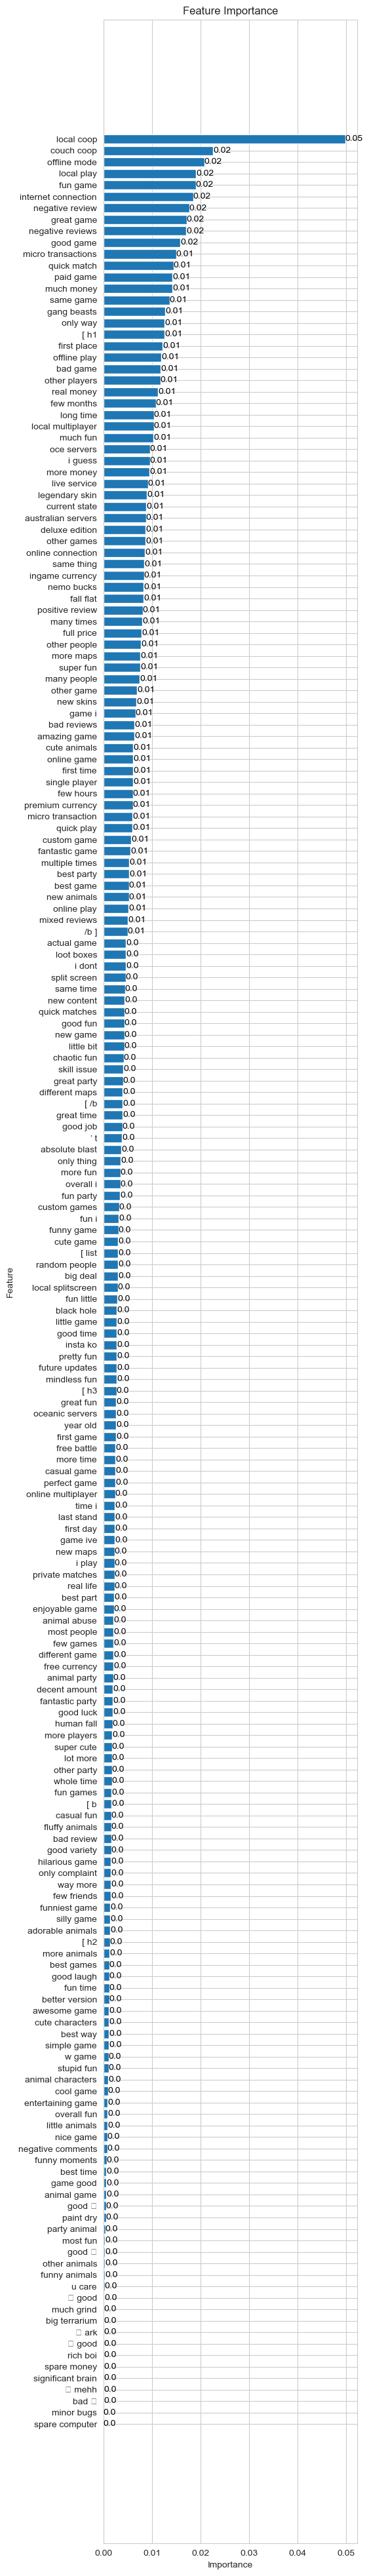

In [ ]:
# Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=6954)
# Train the model
clf.fit(X, Y)
# Use clf to predict the 'voted_up' value for new data
Y_pred = clf.predict(X)

# Get the feature importances from the trained classifier
feature_importances = clf.feature_importances_

# Create a DataFrame with feature names and importances
df_feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame in descending order of importance
df_feature_importances = df_feature_importances.sort_values(by='Importance', ascending=True)

# Plot the horizontal bar chart
plt.figure(figsize=(5, 50))
plt.barh(df_feature_importances['Feature'], df_feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Add the numerical values to the plot
for i, v in enumerate(df_feature_importances['Importance']):
    plt.text(v, i, str(round(v, 2)), color='black', va='center')
plt.show()

##### Findings

Attributes like "much inconsistency," "grey screen," and "additional points" have the highest importance scores. This suggests that these factors greatly influence a user's decision to recommend a game. For instance, "much inconsistency" might refer to inconsistent gameplay or performance, which negatively affects user recommendations.

#### Identify the top 200 attributes and Perform RF on Segment 1

In [ ]:
df_1 = segment_1

In [ ]:
if not isinstance(df_1['attributes_patterns'].iloc[0], str):
    pass
else:
    df_1['attributes_patterns'] = df_1['attributes_patterns'].str.strip('[]').str.split(', ')

# Flatten the list of lists and count occurrences of each word
word_counts = Counter(word for words in df_1['attributes_patterns'] for word in words)

# Create a DataFrame from the word counts
df_word_counts = pd.DataFrame.from_dict(word_counts, orient='index', columns=['Count'])

# Reset the index
df_word_counts.reset_index(inplace=True)

# Rename the columns
df_word_counts.columns = ['Word', 'Count']

# Sort the DataFrame in descending order of the count
df_word_counts = df_word_counts.sort_values(by='Count', ascending=False)

# Reset the index after sorting
df_word_counts.reset_index(drop=True, inplace=True)

df_word_counts = df_word_counts[df_word_counts['Word'] != '']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ h1\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'’ t\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'/b ]\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ list\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ h3\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'* ]\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ b\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'* *\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ h2\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ url=https\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'] random\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'/list ]\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'//storage.googleapis.com/rebos_american_hamburger_stash/grabbing_issues_2.mp4 ]\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'//storage.googleapis.com/rebos_american_hamburger_stash/grabbing_issues.mp4 ]\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ /list\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'[ /h3\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'/h2 ]\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'/h1 ]\'']
df_word_counts = df_word_counts[df_word_counts['Word'] != '\'//storage.googleapis.com/rebos_american_hamburger_stash/another_bomba_bridge.mp4 ]\'']

# Get the top 200 words
top_200_words = df_word_counts['Word'].head(200)
top_200_words.reset_index(drop=True, inplace=True)
top_200_words

0              good game
1               fun game
2             great game
3                 game i
4           offline mode
             ...        
195             best way
196           casual fun
197           loot boxes
198            good luck
199    local splitscreen
Name: Word, Length: 200, dtype: object

In [ ]:
# Iterate over the top 200 words and create new columns in the original DataFrame
for word in top_200_words:
    df_1[word] = df_1['attributes_patterns'].apply(lambda x: 1 if word in x else 0)

/var/folders/dx/3j4_9y9n65sb4cftdp89qfnc0000gn/T/ipykernel_5487/804602580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[word] = df_1['attributes_patterns'].apply(lambda x: 1 if word in x else 0)
/var/folders/dx/3j4_9y9n65sb4cftdp89qfnc0000gn/T/ipykernel_5487/804602580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1[word] = df_1['attributes_patterns'].apply(lambda x: 1 if word in x else 0)
/var/folders/dx/3j4_9y9n65sb4cftdp89qfnc0000gn/T/ipykernel_5487/804602580.py:3: SettingWithCopyWarni

/Users/addisonji/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9744 (\N{BALLOT BOX}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/addisonji/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9745 (\N{BALLOT BOX WITH CHECK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


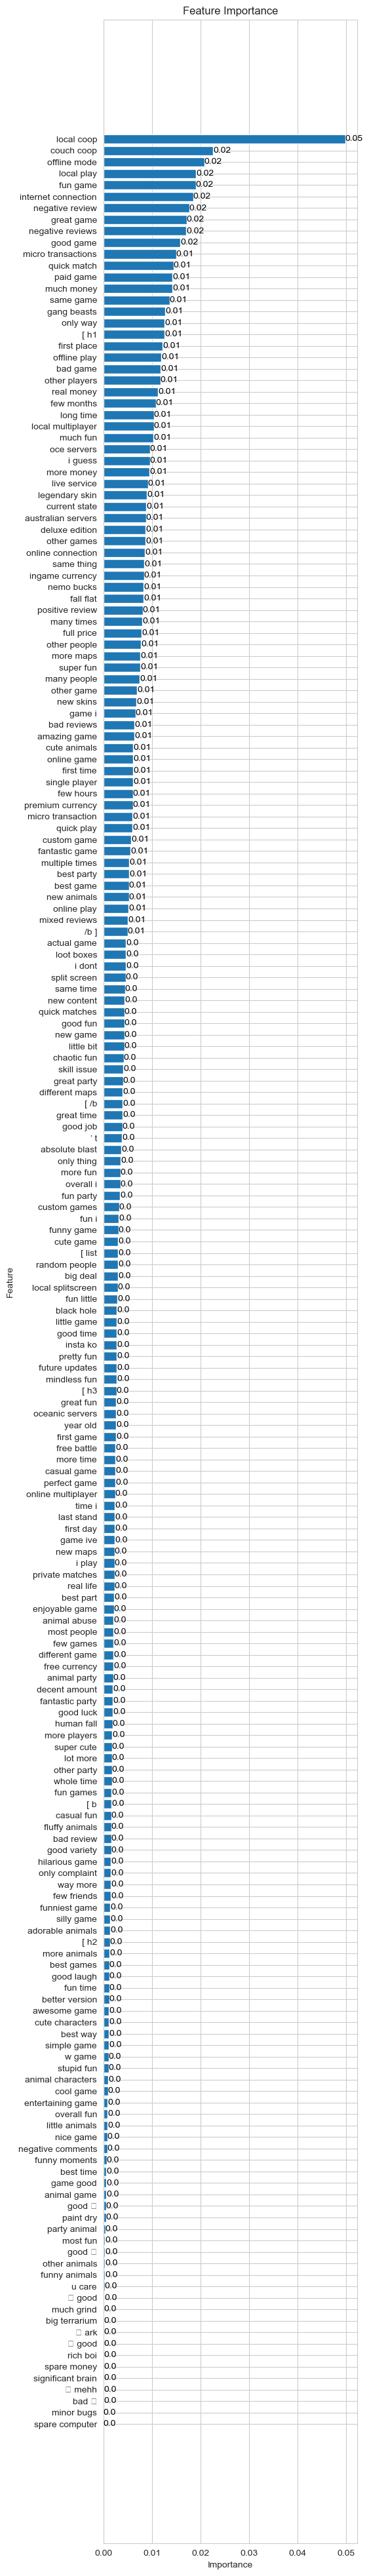

In [ ]:
# Define your X and Y
X = df_1.drop(['voted_up',
             'recommendationid',
             'language',
             'review',
             'timestamp_created',
             'timestamp_updated',
             'votes_up',
             'votes_funny',
             'weighted_vote_score',
             'comment_count',
             'steam_purchase',
             'received_for_free',
             'written_during_early_access',
             'hidden_in_steam_china',
             'steam_china_location',
             'timestamp_dev_responded',
             'developer_response',
             'steamid',
             'num_games_owned',
             'num_reviews',
             'playtime_forever',
             'playtime_last_two_weeks',
             'playtime_at_review',
             'last_played',
             'attributes_patterns',
             'POS_all',
             'cluster',
             'sentiment_scores_noun_pos_vader',
             'sentiment_score_noun_pos_vader',
             'sentiment_scores_all_pos_vader',
             'sentiment_score_all_pos_vader',
             'sentiment_score_review_spacy' ,
             'sentiment_score_noun_pos_spacy',
             'sentiment_score_all_pos_spacy',
             'consistency_noun_pos_vader',
             'consistency_all_pos_vader',
             'consistency_review_spacy',
             'consistency_noun_pos_spacy',
             'consistency_all_pos_spacy'],
             axis=1)
Y = df_1['voted_up']

# Create a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=6954)

# Train the model
clf.fit(X, Y)

# Use clf to predict the 'voted_up' value for new data
Y_pred = clf.predict(X)

# Get the feature importances from the trained classifier
feature_importances = clf.feature_importances_

# Create a DataFrame with feature names and importances
df_feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame in descending order of importance
df_feature_importances = df_feature_importances.sort_values(by='Importance', ascending=True)

# Plot the horizontal bar chart
plt.figure(figsize=(5, 50))
plt.barh(df_feature_importances['Feature'], df_feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')

# Add the numerical values to the plot
for i, v in enumerate(df_feature_importances['Importance']):
    plt.text(v, i, str(round(v, 2)), color='black', va='center')
plt.show()

##### Findings:
Local Co-op, Couch Co-op, and Offline Play: These features have the highest importance scores in the model, suggesting that whether a game supports local cooperative play or can be played offline are significant factors in whether users recommend the game. This might imply that games with social or non-internet reliant aspects are more likely to be recommended in this cluster.

Linear Decrease in Importance: The importance scores decrease almost linearly as move down the list of features. This indicates that the most important features are significantly more influential than the least important ones.

Majority of Features with Low Importance: Most of the features have a very low importance score, which suggests they have little influence on the outcome variable (whether a user recommends a game). This could mean that these features do not significantly differentiate between games that are recommended and those that are not within this cluster.

### Feature Impact Analysis
To understand the impact of each identified game attribute, we perform logistic regression for both clusters on the top 15 attributes. The regression coefficients provide insights into the extent to which each feature influences users' recommendations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

#### Pefrom logistic regression on the top 15 attributes on Segment 0

In [ ]:
Y = df_0['voted_up']

#Top 15 feature
X = df_0[['much inconsistency',
        'whole point',
        'grey screen',
        'current state',
        'additional levels',
        'new game',
        'game unplayable',
        'launch day',
        'other games',
        'offline play',
        'i bet',
        'weekly missions',
        'cute game',
        'real money',
        'more time']]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, Y_train)


Y_pred = logistic_model.predict(X_test)

# Calculate accuracy, confusion matrix, and classification report
accuracy = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

accuracy, conf_matrix,

(0.9483870967741935,
 array([[  0,   8],
        [  0, 147]]))

In [ ]:
# Extracting the coefficients of the logistic regression model
coefficients = logistic_model.coef_[0]

feature_names = X.columns
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coefficients_df

,Feature,Coefficient
0,much inconsistency,-0.837834
1,whole point,0.072270
2,grey screen,-0.837834
3,current state,-1.467132
4,additional levels,-0.709151
5,new game,-0.709151
6,game unplayable,-1.371582
7,launch day,-0.709151
8,other games,-1.141064
9,offline play,-0.602104


##### Findings

From the logtic regression, the "current state", "game unplayable", "other games" are the ones has the stronger negative impact on the likelihood of recommendation which suggest to further dig out the root causes. For investment team, they should take these keywords and search the original review posts to understand the issue and then investigate with the founding team.

#### Pefrom logistic regression on the top 15 attributes on Segment 1

In [ ]:
Y_1 = df_1['voted_up']

#Top 15 feature
X_1 = df_1[['local coop',
        'offline mode',
        'couch coop',
        'local play',
        'internet connection',
        'fun game',
        'negative review',
        'good game',
        'micro transactions',
        'paid game',
        'great game',
        'much money',
        'quick match',
        'same game',
        'offline play']]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, X_test, Y_train, Y_test = train_test_split(X_1, Y_1, test_size=0.3, random_state=42)

# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, Y_train)


Y_pred = logistic_model.predict(X_test)

# Calculate accuracy, confusion matrix, and classification report
accuracy = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

accuracy, conf_matrix,

(0.8852785145888594,
 array([[   2,  341],
        [   5, 2668]]))

In [ ]:
# Extracting the coefficients of the logistic regression model
coefficients = logistic_model.coef_[0]

feature_names = X_1.columns
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

coefficients_df

,Feature,Coefficient
0,local coop,-2.104198
1,offline mode,-0.838071
2,couch coop,-1.378418
3,local play,-1.752956
4,internet connection,-1.189286
5,fun game,0.445445
6,negative review,-1.451620
7,good game,0.755277
8,micro transactions,-0.677766
9,paid game,-1.418041


##### Findings

The analysis reveals that features related to local multiplayer options (local coop, couch coop, and offline mode) are negatively associated with the model's outcome, suggesting a preference for online or single-player experiences among the target audience. Positive coefficients for "fun game," "good game," and "great game" highlight the critical importance of game quality in driving favorable outcomes. To enhance game reception and success, developers should focus on delivering high-quality, engaging single-player or online experiences while carefully considering the implementation of local multiplayer features.